# Framingham heart disease study (See below link for the details)

In [1]:

#https://en.wikipedia.org/wiki/Framingham_Heart_Study
#https://en.wikipedia.org/wiki/Coronary_artery_disease
#http://cvdrisk.nhlbi.nih.gov/

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.grid_search import GridSearchCV
from sklearn import svm
from sklearn.preprocessing import Imputer

import theano.tensor as T
from theano import function
from theano import shared
import theano
from theano.tensor.signal import downsample
from theano.tensor.nnet import conv
import matplotlib.pyplot as plt
import scipy.optimize as opt
import glob
import os
import sys
%matplotlib inline

In [3]:
framinghhamDataFrame = pd.read_csv('framingham.csv')

In [4]:
#visualization data
print type(framinghhamDataFrame)
print framinghhamDataFrame.shape
print framinghhamDataFrame.head()

<class 'pandas.core.frame.DataFrame'>
(4240, 16)
   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39          4              0           0       0                0   
1     0   46          2              0           0       0                0   
2     1   48          1              1          20       0                0   
3     0   61          3              1          30       0                0   
4     0   46          3              1          23       0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0      195  106.0     70  26.97         80       77   
1             0         0      250  121.0     81  28.73         95       76   
2             0         0      245  127.5     80  25.34         75       70   
3             1         0      225  150.0     95  28.58         65      103   
4             0         0      285  130.0     84  23.10         85       85   

 

In [5]:
#check to see if there are any NA value, if so 
#For now I am just dropping NA value, but its better to do impute with mean or meadian value latter.

print np.unique(framinghhamDataFrame.isnull())
print framinghhamDataFrame.isnull().values.any()

#imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
#imp.fit(framinghhamDataFrame[predictors])
#X = imp.transform(framinghhamDataFrame[predictors])

#print framinghhamDataFrame.shape
framinghhamDataFrame = framinghhamDataFrame.dropna(axis=0)
print framinghhamDataFrame.shape

print np.unique(framinghhamDataFrame.isnull())
print framinghhamDataFrame.isnull().values.any()

[False  True]
True
(3658, 16)
[False]
False


In [6]:
#We are trying to predict TenYearCHD 
#Splitting the data for classification purpose..
#Input dataframe consists of X1, X2
print framinghhamDataFrame.shape

#Reshuffle the data randomly
framinghhamDataFrame = framinghhamDataFrame.reindex(np.random.permutation(framinghhamDataFrame.index))

X = framinghhamDataFrame.drop(['TenYearCHD'],axis=1) 

print X.shape

#Output vector(predictor/response) vector
Y = framinghhamDataFrame['TenYearCHD']

print Y.shape
#Splitting data into train and testing. 70% Training and 30% Testing..
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=4)


(3658, 16)
(3658, 15)
(3658,)


In [7]:
#Lets visualize the data
print 'X_train=',X_train.shape,' Y_train=',Y_train.shape,' \nX_test=',X_test.shape,' Y_test=',Y_test.shape
print np.unique(Y_train), np.unique(Y_test)

X_train= (2560, 15)  Y_train= (2560,)  
X_test= (1098, 15)  Y_test= (1098,)
[0 1] [0 1]


# Logistic Regression

In [8]:
#Logistic Regression-sklearn
logReg = LogisticRegression()
logReg.fit(X_train,Y_train)
Y_logPred = logReg.predict(X_test)
print metrics.accuracy_score(Y_test,Y_logPred)

#print Y_logPred

0.838797814208


In [9]:
#print confusion matrix
#Confusion matrix of logistic regression
confusion = metrics.confusion_matrix(Y_test,Y_logPred)
print confusion

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[911   6]
 [171  10]]


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2641: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [10]:
print TP, TN, FP, FN

10 911 6 171


In [11]:
#Accuracy
print (TP + TN) / float(TP + TN + FP + FN)
print metrics.accuracy_score(Y_test, Y_logPred)

0.838797814208
0.838797814208


In [12]:
#Classification Error
print (FP + FN) / float(TP + TN + FP + FN)
print 1 - metrics.accuracy_score(Y_test, Y_logPred)

0.161202185792
0.161202185792


In [13]:
#Sensitivity
print TP / float(TP + FN)
print metrics.recall_score(Y_test, Y_logPred)

0.0552486187845
0.0552486187845


In [14]:
#Specifity
print TN / float(TN + FP)

0.993456924755


In [15]:
#False positive rate
print FP / float(TN + FP)

0.00654307524537


In [16]:
#Precision
P = TP / float(TP + FP)
print P
print metrics.precision_score(Y_test, Y_logPred)

0.625
0.625


In [17]:
#Recall
R = TP / float(TP + FN)
print R
print metrics.recall_score(Y_test, Y_logPred)


0.0552486187845
0.0552486187845


In [18]:
#F1 Score
print (2*P*R)/float(P+R)
print metrics.f1_score(Y_test, Y_logPred)

0.10152284264
0.10152284264


In [19]:
# store the predicted probabilities for class 1
Y_logPred_prob = logReg.predict_proba(X_test)[:, 1]

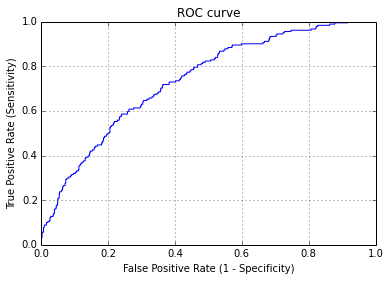

In [20]:
#ROC curve
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_logPred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [21]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print metrics.roc_auc_score(Y_test, Y_logPred)

0.52435277177


In [22]:
# calculate cross-validated AUC
from sklearn.cross_validation import cross_val_score
cross_val_score(logReg, X_test, Y_test, cv=10, scoring='roc_auc').mean()

0.71852275616577665

# Random Forest

In [23]:
#Random Forest Classification
randForest = RandomForestClassifier(n_estimators=30)
randForest.fit(X_train,Y_train)
Y_randForestPred = randForest.predict(X_test)
print metrics.accuracy_score(Y_test,Y_randForestPred)

0.834244080146


In [24]:
#print confusion matrix
#Confusion matrix of logistic regression
confusion = metrics.confusion_matrix(Y_test,Y_randForestPred)
print confusion

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[907  10]
 [172   9]]


In [25]:
#Precision
P = TP / float(TP + FP)
print P
print metrics.precision_score(Y_test, Y_randForestPred)

0.473684210526
0.473684210526


In [26]:
#Recall
R = TP / float(TP + FN)
print R
print metrics.recall_score(Y_test, Y_randForestPred)

0.0497237569061
0.0497237569061


In [27]:
#F1 Score
print (2*P*R)/float(P+R)
print metrics.f1_score(Y_test, Y_randForestPred)

0.09
0.09


In [28]:
# store the predicted probabilities for class 1
Y_randForestPred = randForest.predict_proba(X_test)[:, 1]

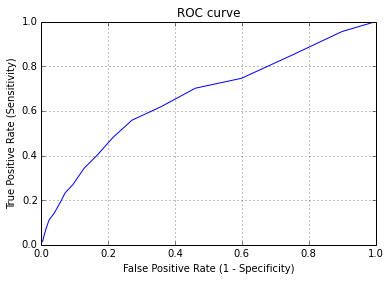

In [29]:
#ROC curve
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_randForestPred)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# Support Vector Machine (SVM)

In [30]:
#Support Vector Machine
#svc = svm.SVC(kernel='linear',C=10, max_iter=1000)
svc = svm.LinearSVC(C=8, loss='hinge', max_iter=1000)
svc

LinearSVC(C=8, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [31]:
Y_svmPred = svc.fit(X_train,Y_train).predict(X_test)
svc.score(X_test, Y_test)

0.16484517304189436

In [34]:
#print confusion matrix
#Confusion matrix of logistic regression
confusion = metrics.confusion_matrix(Y_test,Y_svmPred)
print confusion

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[  0 917]
 [  0 181]]


In [35]:
#Precision
P = TP / float(TP + FP)
print P
print metrics.precision_score(Y_test, Y_svmPred)

0.164845173042
0.164845173042


In [36]:
#Recall
R = TP / float(TP + FN)
print R
print metrics.recall_score(Y_test, Y_svmPred)

1.0
1.0


In [37]:
#F1 Score
print (2*P*R)/float(P+R)
print metrics.f1_score(Y_test, Y_svmPred)

0.283033620016
0.283033620016


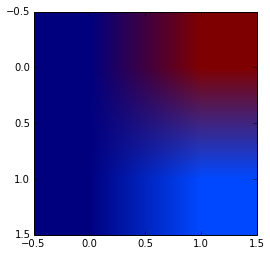

In [38]:
#Heat map for confusion matrix
plt.imshow(confusion)

In [39]:
# store the predicted probabilities for class 1
Y_svcPred_prob = svc.predict_proba(X_test)[:, 1]

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

# Neural Network (Keras)

In [53]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

In [57]:
model = Sequential()
model.add(Dense(10, input_dim=15, init='uniform', activation='tanh'))
#model.add(Dropout(0.5))
#model.add(Dense(8, init='uniform', activation='tanh'))
#model.add(Dropout(0.5))
model.add(Dense(2, init='uniform', activation='softmax'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

In [55]:
"""model = Sequential()
model.add(Dense(output_dim=10, input_dim=15, init="glorot_uniform"))
model.add(Activation("relu"))
model.add(Dense(output_dim=2, init="glorot_uniform"))
model.add(Activation("softmax"))
"""

'model = Sequential()\nmodel.add(Dense(output_dim=10, input_dim=15, init="glorot_uniform"))\nmodel.add(Activation("relu"))\nmodel.add(Dense(output_dim=2, init="glorot_uniform"))\nmodel.add(Activation("softmax"))\n'

In [46]:
#model.compile(loss='categorical_crossentropy', optimizer='sgd')

In [47]:
#model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True))

In [58]:
#model.fit(X_train, Y_train, nb_epoch=5, batch_size=32)
model.fit(X_train, Y_train)
#model.train_on_batch(X_batch, Y_batch)
#objective_score = model.evaluate(X_test, Y_test, batch_size=32)
objective_score = model.evaluate(X_test, Y_test)

#classes = model.predict_classes(X_test, batch_size=32)
#proba = model.predict_proba(X_test, batch_size=32)

Epoch 1/100


IndexError: indices are out-of-bounds

In [ ]:
classes = model.predict_classes(X_test, batch_size=32)
proba = model.predict_proba(X_test, batch_size=32)

# Deep Neural Network (Theano)

In [108]:
def load_data():
    ''' Loads the dataset
    '''

    #############
    # LOAD DATA #
    #############

    print '... loading data'

    # Load the dataset
    train_set = [np.asarray(X_train), np.asarray(Y_train)]
    test_set = [np.asarray(X_test), np.asarray(Y_test)]
    
    #train_set, valid_set format: tuple(input, target)
    #input is an numpy.ndarray of 2 dimensions (a matrix)
    #witch row's correspond to an example. target is a
    #numpy.ndarray of 1 dimensions (vector)) that have the same length as
    #the number of rows in the input. It should give the target
    #target to the example with the same index in the input.

    def shared_dataset(data_xy, borrow=True):
        """ Function that loads the dataset into shared variables

        The reason we store our dataset in shared variables is to allow
        Theano to copy it into the GPU memory (when code is run on GPU).
        Since copying data into the GPU is slow, copying a minibatch everytime
        is needed (the default behaviour if the data is not in a shared
        variable) would lead to a large decrease in performance.
        """
        data_x, data_y = data_xy
        shared_x = theano.shared(np.asarray(data_x,
                                               dtype=theano.config.floatX),
                                 borrow=borrow)
        shared_y = theano.shared(np.asarray(data_y,
                                               dtype=theano.config.floatX),
                                 borrow=borrow)
        # When storing data on the GPU it has to be stored as floats
        # therefore we will store the labels as ``floatX`` as well
        # (``shared_y`` does exactly that). But during our computations
        # we need them as ints (we use labels as index, and if they are
        # floats it doesn't make sense) therefore instead of returning
        # ``shared_y`` we will have to cast it to int. This little hack
        # lets ous get around this issue
        return shared_x, T.cast(shared_y, 'int32')

    train_set_x, train_set_y = shared_dataset(train_set)
    test_set_x, test_set_y   = shared_dataset(test_set)    

    rval = [(train_set_x, train_set_y), (test_set_x, test_set_y)]
    return rval

In [109]:
class LogisticRegression(object):
    """Multi-class Logistic Regression Class

    The logistic regression is fully described by a weight matrix :math:`W`
    and bias vector :math:`b`. Classification is done by projecting data
    points onto a set of hyperplanes, the distance to which is used to
    determine a class membership probability.
    """

    def __init__(self, input, n_in, n_out):
        """ Initialize the parameters of the logistic regression

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
                      architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
                     which the datapoints lie

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
                      which the labels lie

        """
        
        # initialize with 0 the weights W as a matrix of shape (n_in, n_out)
        self.W = theano.shared(value=np.zeros((n_in, n_out),
                                                 dtype=theano.config.floatX),
                                name='W', borrow=True)
        # initialize the biases b as a vector of n_out 0s
        self.b = theano.shared(value=np.zeros((n_out,),
                                                 dtype=theano.config.floatX),
                               name='b', borrow=True)

        # compute vector of class-membership probabilities in symbolic form
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)

        # compute prediction as class whose probability is maximal in
        # symbolic form
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)

        # parameters of the model
        self.params = [self.W, self.b]

    def negative_log_likelihood(self, y):
        """Return the mean of the negative log-likelihood of the prediction
        of this model under a given target distribution.

        .. math::

            \frac{1}{|\mathcal{D}|} \mathcal{L} (\theta=\{W,b\}, \mathcal{D}) =
            \frac{1}{|\mathcal{D}|} \sum_{i=0}^{|\mathcal{D}|} \log(P(Y=y^{(i)}|x^{(i)}, W,b)) \\
                \ell (\theta=\{W,b\}, \mathcal{D})

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label

        Note: we use the mean instead of the sum so that
              the learning rate is less dependent on the batch size
        """
        # y.shape[0] is (symbolically) the number of rows in y, i.e.,
        # number of examples (call it n) in the minibatch
        # T.arange(y.shape[0]) is a symbolic vector which will contain
        # [0,1,2,... n-1] T.log(self.p_y_given_x) is a matrix of
        # Log-Probabilities (call it LP) with one row per example and
        # one column per class LP[T.arange(y.shape[0]),y] is a vector
        # v containing [LP[0,y[0]], LP[1,y[1]], LP[2,y[2]], ...,
        # LP[n-1,y[n-1]]] and T.mean(LP[T.arange(y.shape[0]),y]) is
        # the mean (across minibatch examples) of the elements in v,
        # i.e., the mean log-likelihood across the minibatch.
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])

    def errors(self, y):
        """Return a float representing the number of errors in the minibatch
        over the total number of examples of the minibatch ; zero one
        loss over the size of the minibatch

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label
        """

        # check if y has same dimension of y_pred
        if y.ndim != self.y_pred.ndim:
            raise TypeError('y should have the same shape as self.y_pred',
                ('y', target.type, 'y_pred', self.y_pred.type))
        # check if y is of the correct datatype
        if y.dtype.startswith('int'):
            # the T.neq operator returns a vector of 0s and 1s, where 1
            # represents a mistake in prediction
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()
            
    def predict(self):
        return self.y_pred


In [110]:
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dmatrix
        :param input: a symbolic tensor of shape (n_examples, n_in)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: theano.Op or function
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input = input

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # for tanh activation function
        # the output of uniform if converted using asarray to dtype
        # theano.config.floatX so that the code is runable on GPU
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        if W is None:
            W_values = np.asarray(rng.uniform(
                    low=-np.sqrt(6. / (n_in + n_out)),
                    high=np.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)), dtype=theano.config.floatX)
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (lin_output if activation is None
                       else activation(lin_output))
        # parameters of the model
        self.params = [self.W, self.b]


class MLP(object):
    """Multi-Layer Perceptron Class

    A multilayer perceptron is a feedforward artificial neural network model
    that has one layer or more of hidden units and nonlinear activations.
    Intermediate layers usually have as activation function tanh or the
    sigmoid function (defined here by a ``HiddenLayer`` class)  while the
    top layer is a softamx layer (defined here by a ``LogisticRegression``
    class).
    """

    def __init__(self, rng, input, n_in, n_hidden, n_out):
        
        """Initialize the parameters for the multilayer perceptron

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
        architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
        which the datapoints lie

        :type n_hidden: int
        :param n_hidden: number of hidden units

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
        which the labels lie

        """

        # Since we are dealing with a one hidden layer MLP, this will translate
        # into a HiddenLayer with a tanh activation function connected to the
        # LogisticRegression layer; the activation function can be replaced by
        # sigmoid or any other nonlinear function
        self.hiddenLayer = HiddenLayer(rng=rng, input=input,
                                       n_in=n_in, n_out=n_hidden,
                                       activation=T.tanh)
        print n_in, n_hidden, n_out
        # The logistic regression layer gets as input the hidden units
        # of the hidden layer
        
        self.logRegressionLayer = LogisticRegression(input=self.hiddenLayer.output, n_in = n_hidden, n_out=n_out)
        
        print n_in, n_hidden, n_out
        # L1 norm ; one regularization option is to enforce L1 norm to
        # be small
        self.L1 = abs(self.hiddenLayer.W).sum() \
                + abs(self.logRegressionLayer.W).sum()

        # square of L2 norm ; one regularization option is to enforce
        # square of L2 norm to be small
        self.L2_sqr = (self.hiddenLayer.W ** 2).sum() \
                    + (self.logRegressionLayer.W ** 2).sum()

        # negative log likelihood of the MLP is given by the negative
        # log likelihood of the output of the model, computed in the
        # logistic regression layer
        self.negative_log_likelihood = self.logRegressionLayer.negative_log_likelihood
        # same holds for the function computing the number of errors
        self.errors = self.logRegressionLayer.errors

        # the parameters of the model are the parameters of the two layer it is
        # made out of
        self.params = self.hiddenLayer.params + self.logRegressionLayer.params
        self.predict = self.logRegressionLayer.predict

In [111]:
learning_rate=0.025
L1_reg=0.001
L2_reg=0.0001
n_epochs= 100
batch_size=100
n_hidden=100

datasets = load_data()

train_set_x, train_set_y = datasets[0]
test_set_x , test_set_y = datasets[1]

# compute number of minibatches for training, validation and testing
n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size
n_test_batches = test_set_x.get_value(borrow=True).shape[0] / batch_size

######################
# BUILD ACTUAL MODEL #
######################
print '... building the model'

# allocate symbolic variables for the data
index = T.lscalar()  # index to a [mini]batch
x = T.matrix('x')  # the data is presented as rasterized images
y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels

rng = np.random.RandomState(1234)

# construct the MLP class
classifier = MLP(rng=rng, input=x, n_in=15, n_hidden=n_hidden, n_out=2)

# the cost we minimize during training is the negative log likelihood of
# the model plus the regularization terms (L1 and L2); cost is expressed
# here symbolically
cost = classifier.negative_log_likelihood(y) \
        + L1_reg * classifier.L1 \
        + L2_reg * classifier.L2_sqr

# compiling a Theano function that computes the mistakes that are made
# by the model on a minibatch

test_model = theano.function(inputs=[index],
            outputs=classifier.errors(y),
            givens={
                x: test_set_x[index * batch_size:(index + 1) * batch_size],
                y: test_set_y[index * batch_size:(index + 1) * batch_size]})

    # compute the gradient of cost with respect to theta (sotred in params)
    # the resulting gradients will be stored in a list gparams
gparams = []
for param in classifier.params:
    gparam = T.grad(cost, param)
    gparams.append(gparam)

# specify how to update the parameters of the model as a list of
# (variable, update expression) pairs
updates = []
# given two list the zip A = [a1, a2, a3, a4] and B = [b1, b2, b3, b4] of
# same length, zip generates a list C of same size, where each element
# is a pair formed from the two lists :
#    C = [(a1, b1), (a2, b2), (a3, b3), (a4, b4)]
for param, gparam in zip(classifier.params, gparams):
    updates.append((param, param - learning_rate * gparam))

# compiling a Theano function `train_model` that returns the cost, but
# in the same time updates the parameter of the model based on the rules
# defined in `updates`
train_model = theano.function(inputs=[index], outputs=cost,
            updates=updates,
            givens={
                x: train_set_x[index * batch_size:(index + 1) * batch_size],
                y: train_set_y[index * batch_size:(index + 1) * batch_size]})

###############
# TRAIN MODEL #
###############
print '... training'

# early-stopping parameters
patience = 10000  # look as this many examples regardless
patience_increase = 2  # wait this much longer when a new best is
                        # found
improvement_threshold = 0.995  # a relative improvement of this much is
                                   # considered significant
test_frequency = min(n_train_batches, patience / 2)
                                  # go through this many
                                  # minibatche before checking the network
                                  # on the validation set; in this case we
                                  # check every epoch

best_test_loss = np.inf
best_iter = 0

epoch = 0
done_looping = False

while (epoch < n_epochs) and (not done_looping):
    epoch = epoch + 1
    for minibatch_index in xrange(n_train_batches):

        minibatch_avg_cost = train_model(minibatch_index)
        # iteration number
        iter = (epoch - 1) * n_train_batches + minibatch_index

        if (iter + 1) % test_frequency == 0:
            # compute zero-one loss on validation set
            test_losses = [test_model(i) for i
                                     in xrange(n_test_batches)]
            this_test_loss = np.mean(test_losses)

            print('epoch %i, test error %f %%' %
                     (epoch, this_test_loss * 100.))

            # if we got the best validation score until now
            if this_test_loss < best_test_loss:
                #improve patience if loss improvement is good enough
                if this_test_loss < best_test_loss *  \
                        improvement_threshold:
                    patience = max(patience, iter * patience_increase)

                best_test_loss = this_test_loss

        if patience <= iter:
            done_looping = True
            break


... loading data
... building the model
15 100 2
15 100 2
... training
epoch 1, test error 15.200000 %
epoch 2, test error 15.200000 %
epoch 3, test error 15.200000 %
epoch 4, test error 15.200000 %
epoch 5, test error 15.200000 %
epoch 6, test error 15.200000 %
epoch 7, test error 15.200000 %
epoch 8, test error 15.200000 %
epoch 9, test error 15.200000 %
epoch 10, test error 15.200000 %
epoch 11, test error 15.200000 %
epoch 12, test error 15.100000 %
epoch 13, test error 15.200000 %
epoch 14, test error 15.100000 %
epoch 15, test error 15.200000 %
epoch 16, test error 15.200000 %
epoch 17, test error 15.200000 %
epoch 18, test error 15.200000 %
epoch 19, test error 15.300000 %
epoch 20, test error 15.100000 %
epoch 21, test error 15.200000 %
epoch 22, test error 15.200000 %
epoch 23, test error 15.200000 %
epoch 24, test error 15.200000 %
epoch 25, test error 15.200000 %
epoch 26, test error 15.200000 %
epoch 27, test error 15.100000 %
epoch 28, test error 15.200000 %
epoch 29, test

In [112]:
100-14.8

85.2